In [130]:
import pandas as pd 
import numpy as np 
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report , confusion_matrix , cohen_kappa_score
from sklearn.utils.class_weight import compute_class_weight
import optuna
import xgboost as xgb




In [ ]:
dfTrain = pd.read_csv("train.csv")


In [99]:

dfTrain["alcohol_sulphates"] = dfTrain["alcohol"] * dfTrain["sulphates"]
dfTrain["volatile_citric"] = dfTrain["volatile acidity"] * dfTrain["citric acid"]
dfTrain["total_acidity"] = dfTrain["fixed acidity"] + dfTrain["volatile acidity"]


dfTrain["sulfur_ratio"] = dfTrain["free sulfur dioxide"] / (dfTrain["total sulfur dioxide"] + 1e-5)
dfTrain["sugar_density_ratio"] = dfTrain["residual sugar"] / (dfTrain["density"] + 1e-5)
dfTrain["fixed_acidity_to_volatility"] = dfTrain["fixed acidity"] / (dfTrain["volatile acidity"] + 1e-5)
dfTrain["alcohol_density_interaction"] = dfTrain["alcohol"] * dfTrain["density"]
dfTrain["pH_acidity_interaction"] = dfTrain["pH"] * dfTrain["fixed acidity"]


In [100]:
cols_to_drop = [
    'residual sugar',
    'free sulfur dioxide',
    'total sulfur dioxide',
    'density',
    'volatile_citric',  # déjà représentée via d'autres features
    'alcohol_squared',  # pas utilisé
    'sweet_density',    # probablement colinéaire
    'acid_index',       # redondant avec fixed/volatile
    'alc_density',      # redondant avec alcohol_density_interaction
    'log_sulphates'     # non mentionnée/utilisée
]

dfTrain.drop(columns=[col for col in cols_to_drop if col in dfTrain.columns], inplace=True)

In [101]:
dfTrain.columns

Index(['id', 'fixed acidity', 'volatile acidity', 'citric acid', 'chlorides',
       'pH', 'sulphates', 'alcohol', 'quality', 'alcohol_sulphates',
       'total_acidity', 'sulfur_ratio', 'sugar_density_ratio',
       'fixed_acidity_to_volatility', 'alcohol_density_interaction',
       'pH_acidity_interaction'],
      dtype='object')

In [102]:
cols_to_drop = [
    'volatile_citric',
    'sulfur_ratio',            
    'acid_index',             
    'sweet_density',           
    'alc_density',            
    'alcohol_squared',        
    'log_sulphates',          
]


In [103]:
dfTrain.columns

Index(['id', 'fixed acidity', 'volatile acidity', 'citric acid', 'chlorides',
       'pH', 'sulphates', 'alcohol', 'quality', 'alcohol_sulphates',
       'total_acidity', 'sulfur_ratio', 'sugar_density_ratio',
       'fixed_acidity_to_volatility', 'alcohol_density_interaction',
       'pH_acidity_interaction'],
      dtype='object')

In [104]:
dfTrain.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           15000 non-null  int64  
 1   fixed acidity                15000 non-null  float64
 2   volatile acidity             15000 non-null  float64
 3   citric acid                  15000 non-null  float64
 4   chlorides                    15000 non-null  float64
 5   pH                           15000 non-null  float64
 6   sulphates                    15000 non-null  float64
 7   alcohol                      15000 non-null  float64
 8   quality                      15000 non-null  float64
 9   alcohol_sulphates            15000 non-null  float64
 10  total_acidity                15000 non-null  float64
 11  sulfur_ratio                 15000 non-null  float64
 12  sugar_density_ratio          15000 non-null  float64
 13  fixed_acidity_to

In [105]:
dfTrain.describe()

,id,fixed acidity,volatile acidity,citric acid,chlorides,pH,sulphates,alcohol,quality,alcohol_sulphates,total_acidity,sulfur_ratio,sugar_density_ratio,fixed_acidity_to_volatility,alcohol_density_interaction,pH_acidity_interaction
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,7499.500000,8.153813,0.505495,0.231547,0.078896,3.322159,0.620184,10.190577,5.643933,6.326690,8.659308,0.380877,2.198850,17.746096,10.159017,27.019633
std,4330.271354,1.398083,0.134842,0.176786,0.015516,0.116639,0.109148,0.899417,0.798160,1.283104,1.359417,0.127916,0.530096,7.306372,0.895259,4.296616
min,0.000000,0.690000,0.120000,0.000000,0.012000,2.880000,0.390000,8.800000,3.000000,3.588000,1.415000,0.020408,1.081503,0.951711,8.763744,2.456400
25%,3749.750000,7.200000,0.400000,0.050000,0.073000,3.240000,0.550000,9.500000,5.000000,5.428000,7.710000,0.285714,1.907745,12.419155,9.465800,24.012000
50%,7499.500000,7.800000,0.500000,0.240000,0.078000,3.320000,0.600000,9.900000,6.000000,6.045000,8.360000,0.380000,2.107566,15.713965,9.853074,26.101500
75%,11249.250000,8.900000,0.600000,0.390000,0.084000,3.390000,0.660000,10.800000,6.000000,6.956000,9.380000,0.458504,2.401477,21.189972,10.782720,29.120000
max,14999.000000,15.900000,1.650000,0.740000,0.415000,3.780000,1.950000,14.000000,8.000000,21.255000,16.180000,1.117646,15.136175,105.824515,13.958280,53.808000


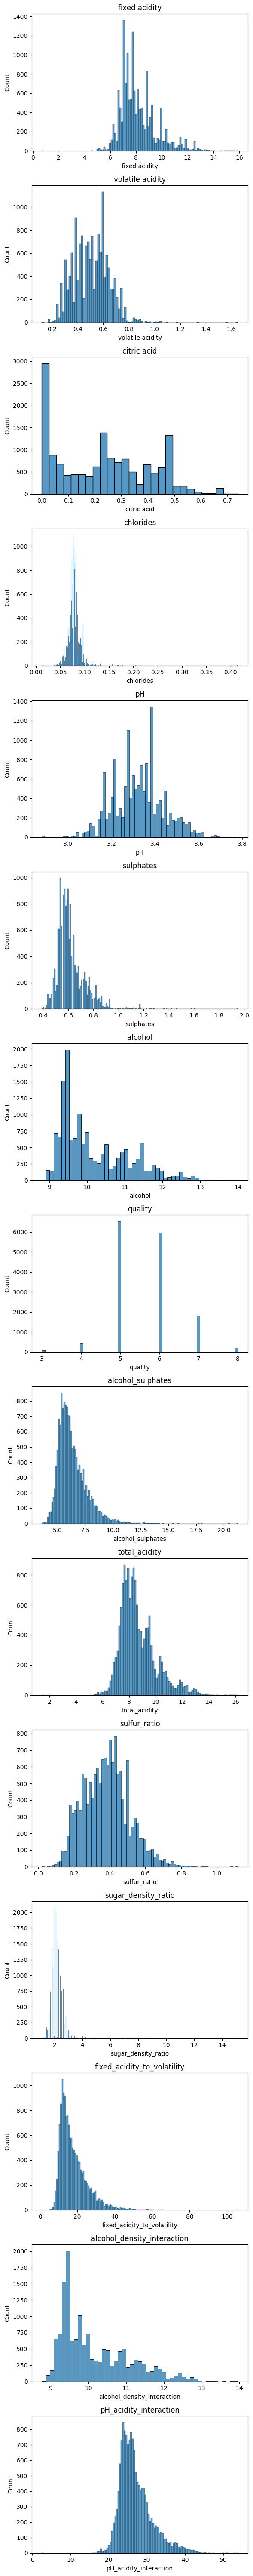

In [106]:
dfTrainNumericalCols = dfTrain.select_dtypes(include = "number")
dfTrainNumericalCols = dfTrainNumericalCols.drop(["id"], axis=1)
num_cols = len(dfTrainNumericalCols.columns)


plt.figure(figsize=(6, 4 * num_cols))

for index, column_name in enumerate(dfTrainNumericalCols.columns, start=1):
    plt.subplot(num_cols, 1, index)
    sns.histplot(dfTrainNumericalCols[column_name].dropna())
    plt.title(f'{column_name}')

plt.tight_layout()
plt.show()

                             fixed acidity  volatile acidity  citric acid  \
fixed acidity                     1.000000         -0.331007     0.615570   
volatile acidity                 -0.331007          1.000000    -0.655895   
citric acid                       0.615570         -0.655895     1.000000   
chlorides                         0.046550         -0.052797     0.074860   
pH                               -0.420896          0.277847    -0.472715   
sulphates                         0.178483         -0.194117     0.238438   
alcohol                           0.025924         -0.057501     0.070175   
quality                           0.032502         -0.005916     0.021746   
alcohol_sulphates                 0.168618         -0.194538     0.239854   
total_acidity                     0.995610         -0.241230     0.568019   
sulfur_ratio                     -0.063669          0.021144    -0.052019   
sugar_density_ratio               0.076810         -0.043436     0.082767   

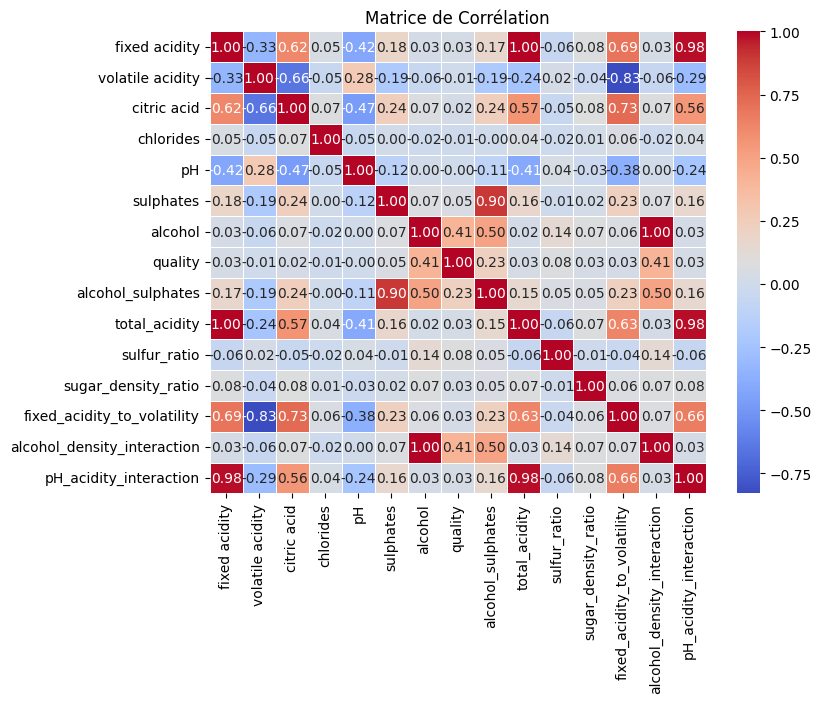

In [107]:
correlation_matrix = dfTrainNumericalCols.corr()
print(correlation_matrix)
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title('Matrice de Corrélation')
plt.show()

quality
5.0    6525
6.0    5959
7.0    1824
4.0     421
8.0     203
3.0      68
Name: count, dtype: int64


<Axes: ylabel='count'>

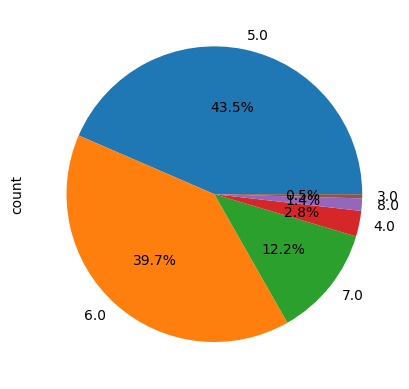

In [108]:
print(dfTrain["quality"].value_counts())

dfTrain["quality"].value_counts().plot(kind='pie',autopct='%1.1f%%')

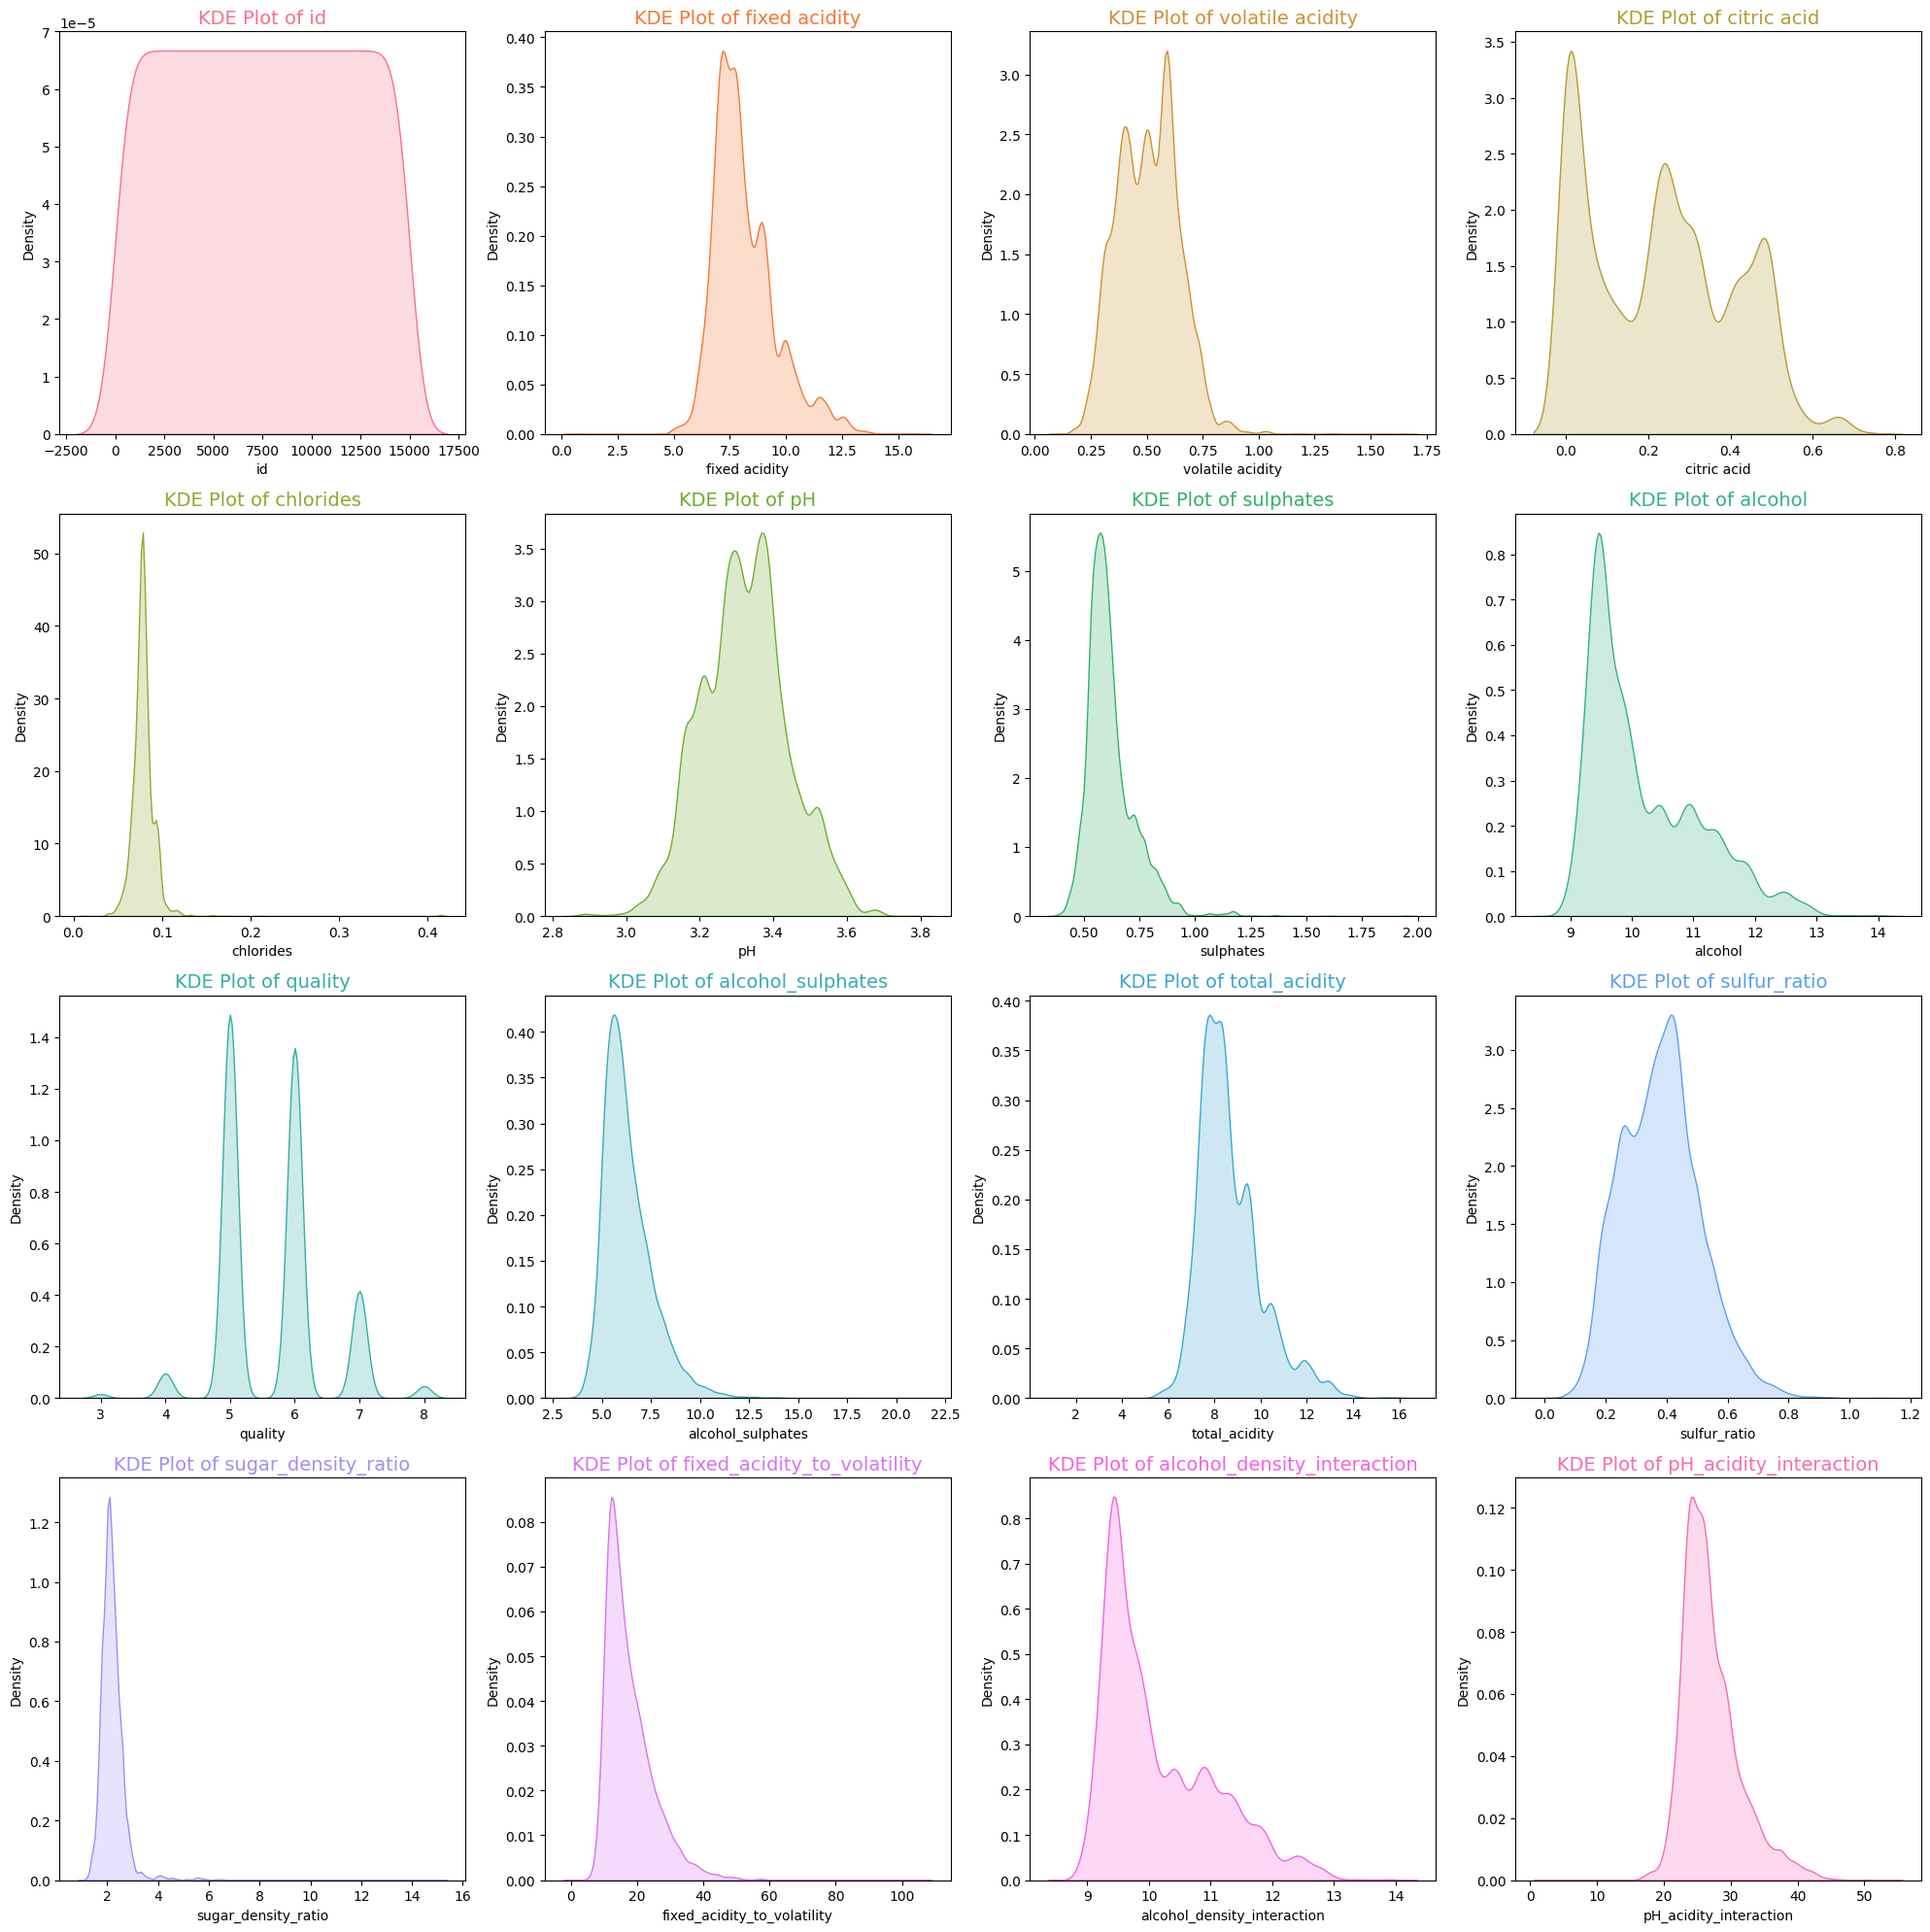

In [109]:
import seaborn as sns
import matplotlib.pyplot as plt

colors = sns.color_palette('husl', len(dfTrain.columns))

rows = -(-len(dfTrain.columns) // 4)
plt.figure(figsize=(20, 5 * rows))

for i, (col, color) in enumerate(zip(dfTrain.columns, colors), 1):
    plt.subplot(rows, 4, i)
    sns.kdeplot(data=dfTrain, x=col, fill=True, color=color)
    plt.title(f'KDE Plot of {col}', fontsize=14, color=color)
    plt.xlabel(col)
    plt.ylabel('Density')

plt.tight_layout()
plt.show()

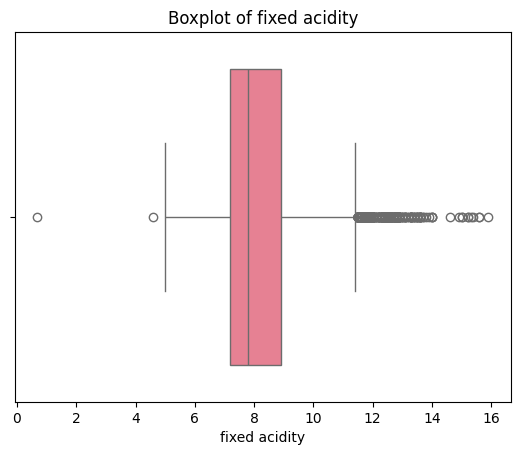

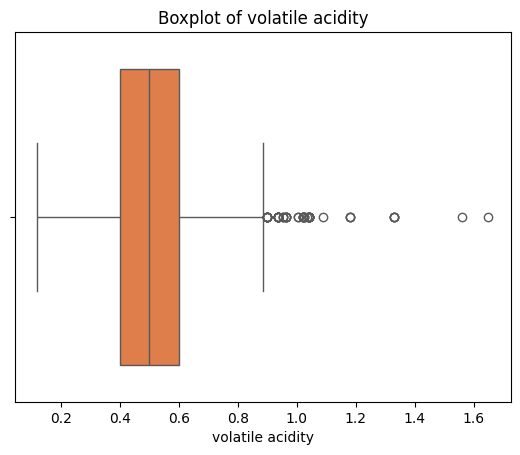

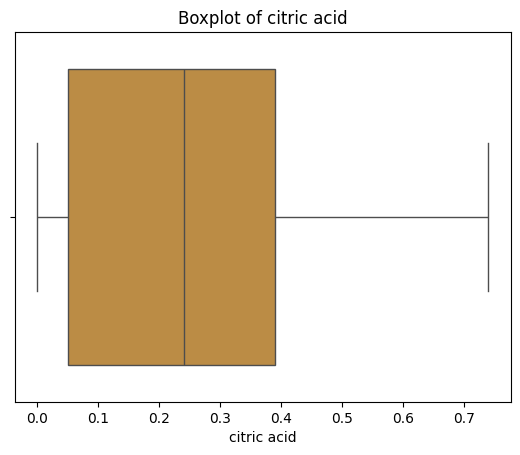

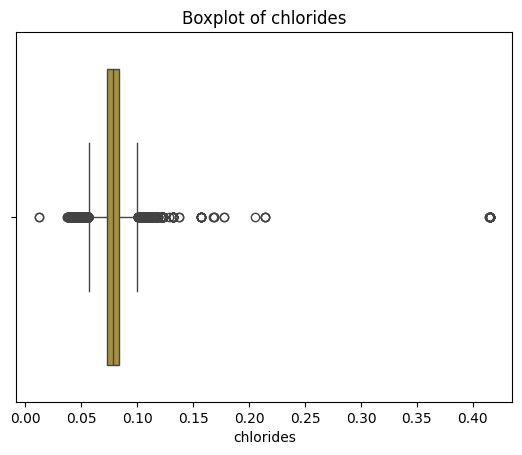

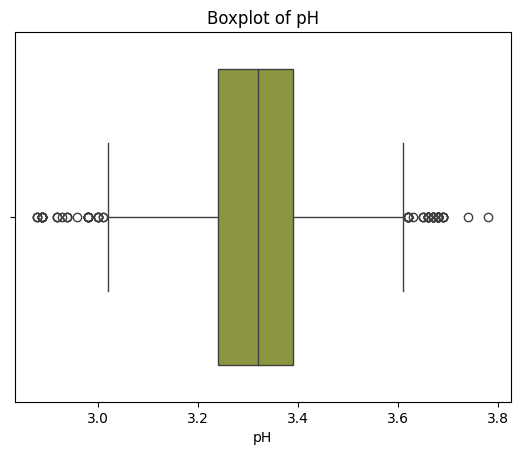

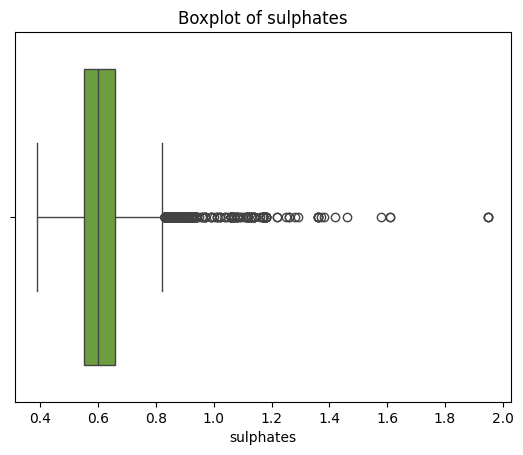

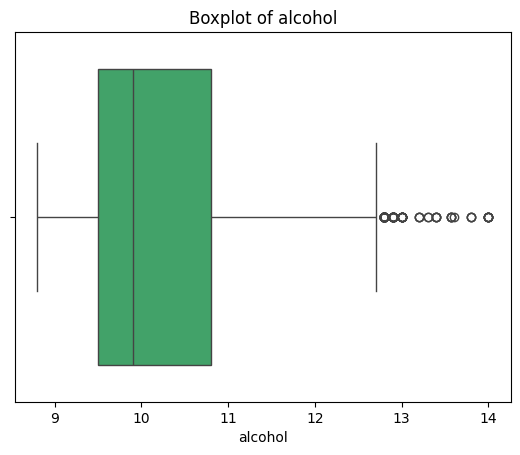

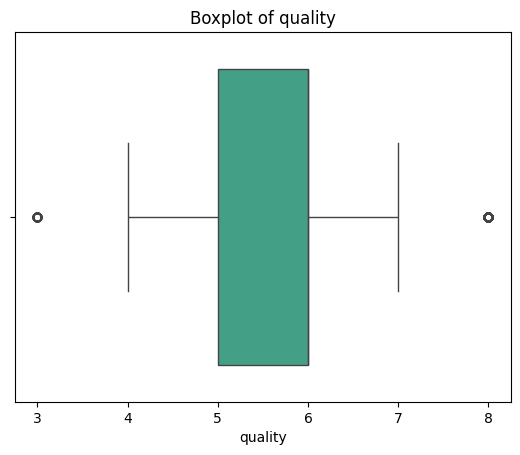

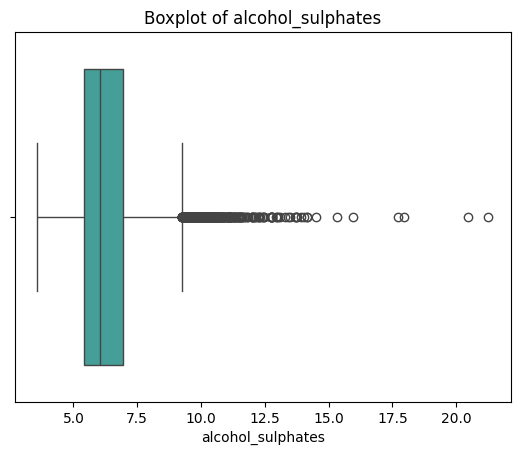

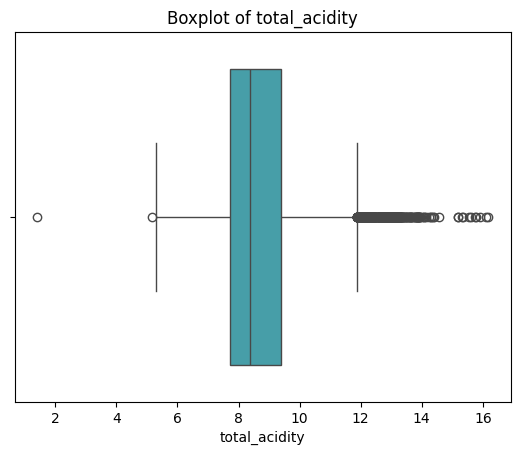

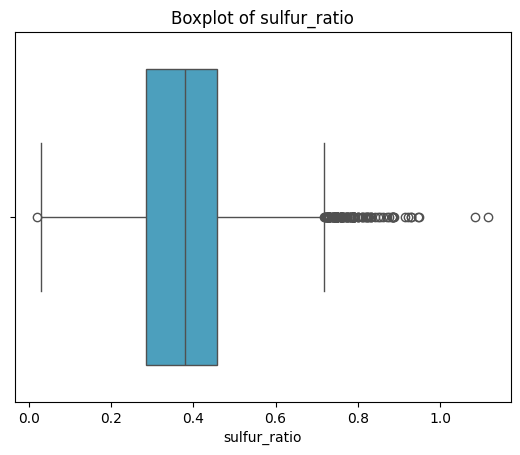

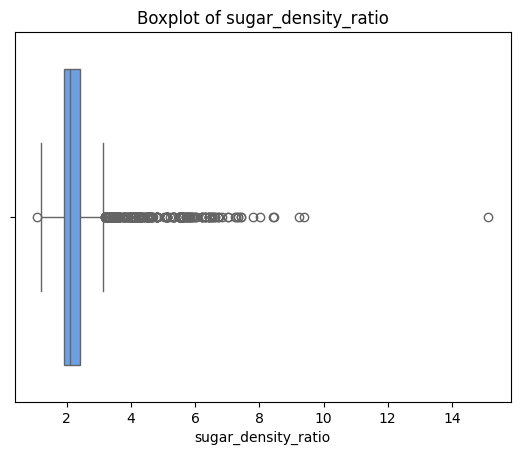

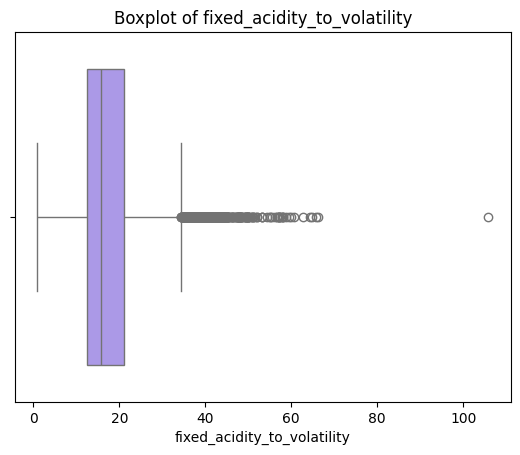

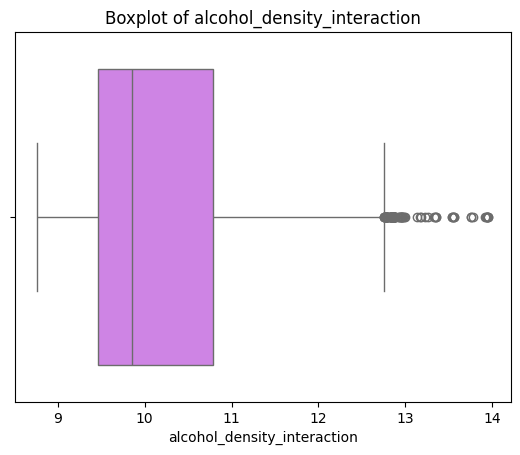

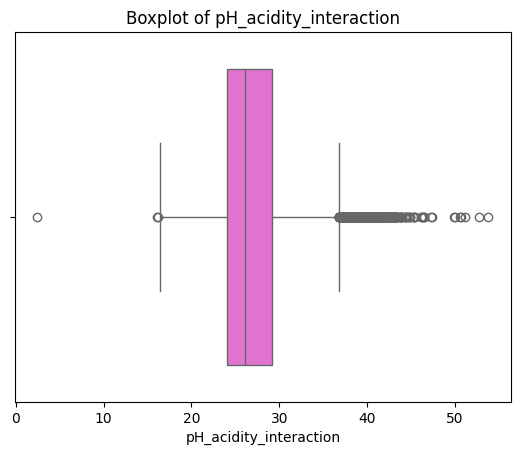

In [110]:
colors = sns.color_palette('husl', len(dfTrain.columns))

for i, col in enumerate(dfTrainNumericalCols.columns):
    sns.boxplot(x=dfTrain[col], color=colors[i]) 
    plt.title(f'Boxplot of {col}')
    plt.show()


train_test_split + SMOTE

In [111]:
X = dfTrain.drop("quality", axis=1)
y = dfTrain["quality"]

le = LabelEncoder()
y = le.fit_transform(y)


X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
X_val_resampled, y_val_resampled = smote.fit_resample(X_val, y_val)


from collections import Counter
print("bf SMOTE :", Counter(y_train))
print("after SMOTE :", Counter(y_train_resampled))
print("after SMOTE :", Counter(y_val_resampled))

c:\Users\gerar\Desktop\githubRepo\-AI-Projects\.venv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


bf SMOTE : Counter({np.int64(2): 5220, np.int64(3): 4767, np.int64(4): 1459, np.int64(1): 337, np.int64(5): 163, np.int64(0): 54})
after SMOTE : Counter({np.int64(4): 5220, np.int64(3): 5220, np.int64(2): 5220, np.int64(5): 5220, np.int64(1): 5220, np.int64(0): 5220})
after SMOTE : Counter({np.int64(2): 1305, np.int64(3): 1305, np.int64(4): 1305, np.int64(1): 1305, np.int64(5): 1305, np.int64(0): 1305})


c:\Users\gerar\Desktop\githubRepo\-AI-Projects\.venv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [112]:
np.unique(y)


array([0, 1, 2, 3, 4, 5])

In [113]:
print(X_train_resampled.shape)  
print(X_val.shape)
print(y_val.shape)   


(31320, 15)
(3000, 15)
(3000,)


Model

In [114]:
model = XGBClassifier(
    eval_metric="mlogloss",
    objective='multi:softmax',
    enable_categorical=True,
    random_state=42 , 
    early_stopping_rounds=50
)

model.fit(
    X_train_resampled, y_train_resampled,
    eval_set=[(X_val_resampled, y_val_resampled)],
    verbose=False 
)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=50,
              enable_categorical=True, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softmax', ...)

In [115]:
y_test = y_val_resampled
y_pred = model.predict(X_val_resampled)

report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df = report_df.drop('accuracy')
report_df

,precision,recall,f1-score,support
0,0.283871,0.134866,0.182857,1305.0
1,0.322118,0.396169,0.355326,1305.0
2,0.509867,0.732567,0.601258,1305.0
3,0.408304,0.271264,0.325967,1305.0
4,0.387470,0.488123,0.432011,1305.0
5,0.293683,0.274330,0.283677,1305.0
macro avg,0.367552,0.382886,0.363516,7830.0
weighted avg,0.367552,0.382886,0.363516,7830.0


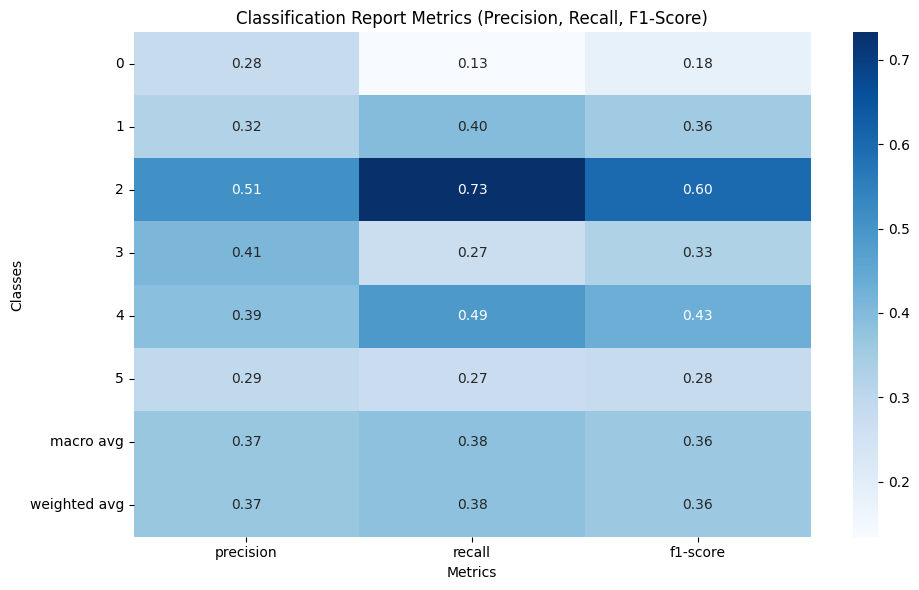

In [116]:


plt.figure(figsize=(10, 6))

sns.heatmap(report_df[['precision', 'recall', 'f1-score']], annot=True, fmt='.2f', cmap="Blues", cbar=True)

plt.title("Classification Report Metrics (Precision, Recall, F1-Score)")
plt.xlabel("Metrics")
plt.ylabel("Classes")
plt.tight_layout()
plt.show()

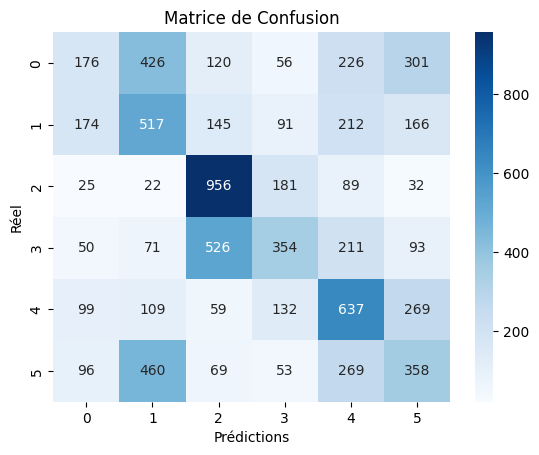

In [117]:
cm = confusion_matrix(y_val_resampled, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de Confusion')
plt.xlabel('Prédictions')
plt.ylabel('Réel')
plt.show()

In [118]:
cohen_kappa_score(y_test, y_pred, weights='quadratic')


np.float64(0.18132634016112636)

In [124]:
def objective(trial):
    params = {
        'objective': 'multi:softmax',
        'eval_metric': 'mlogloss',
        'num_class': 6,
        'random_state': 42,
        'enable_categorical': False,  #
        'learning_rate': trial.suggest_float("learning_rate", 0.01, 0.2),
        'max_depth': trial.suggest_int("max_depth", 3, 8),
        'n_estimators': trial.suggest_int("n_estimators", 100, 500),
        'subsample': trial.suggest_float("subsample", 0.6, 1.0),
        'colsample_bytree': trial.suggest_float("colsample_bytree", 0.6, 1.0),
        'gamma': trial.suggest_float("gamma", 0, 3),
        'reg_alpha': trial.suggest_float("reg_alpha", 0, 5),
        'reg_lambda': trial.suggest_float("reg_lambda", 0, 5)
    }

    model = XGBClassifier(**params, early_stopping_rounds=50)
    model.fit(X_train_resampled, y_train_resampled, eval_set=[(X_val, y_val)], verbose=False)

    y_pred = model.predict(X_val)
    kappa = cohen_kappa_score(y_val, y_pred, weights="quadratic")
    
    return kappa  

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50 ,timeout=600) 

print("Best trial:")
print(study.best_trial.params)

[I 2025-05-13 10:53:05,404] A new study created in memory with name: no-name-430ff185-95de-4943-9b39-70b7bc2e1033
[I 2025-05-13 10:53:07,756] Trial 0 finished with value: 0.2582488146559203 and parameters: {'learning_rate': 0.02551799205943918, 'max_depth': 4, 'n_estimators': 268, 'subsample': 0.8630760598265534, 'colsample_bytree': 0.9432518022491928, 'gamma': 0.5252550328897317, 'reg_alpha': 1.8786206358594326, 'reg_lambda': 3.1366066337268905}. Best is trial 0 with value: 0.2582488146559203.
[I 2025-05-13 10:53:10,018] Trial 1 finished with value: 0.3103850259197598 and parameters: {'learning_rate': 0.1713931150100989, 'max_depth': 7, 'n_estimators': 436, 'subsample': 0.6560897665702881, 'colsample_bytree': 0.9557602091077644, 'gamma': 1.9424043819896086, 'reg_alpha': 0.36152977991103397, 'reg_lambda': 2.429257551675007}. Best is trial 1 with value: 0.3103850259197598.
[I 2025-05-13 10:53:13,046] Trial 2 finished with value: 0.3076249222381624 and parameters: {'learning_rate': 0.117

Best trial:
{'learning_rate': 0.08915256512656927, 'max_depth': 7, 'n_estimators': 228, 'subsample': 0.7517137648682608, 'colsample_bytree': 0.640145416726785, 'gamma': 0.93775240993812, 'reg_alpha': 3.087995151173245, 'reg_lambda': 1.6037930364967083}


In [127]:
best_params = study.best_trial.params

best_params.update({
    'objective': 'multi:softmax',
    'eval_metric': 'mlogloss',
    'num_class': 6,
    'random_state': 42,
    'enable_categorical': False  
})


final_model = XGBClassifier(**best_params)
final_model.fit(X_train_resampled, y_train_resampled)

y_val_pred = final_model.predict(X_val)
final_kappa = cohen_kappa_score(y_val, y_val_pred, weights="quadratic")
print(f"Quadratic Kappa Score sur validation: {final_kappa:.4f}")

Quadratic Kappa Score sur validation: 0.3312


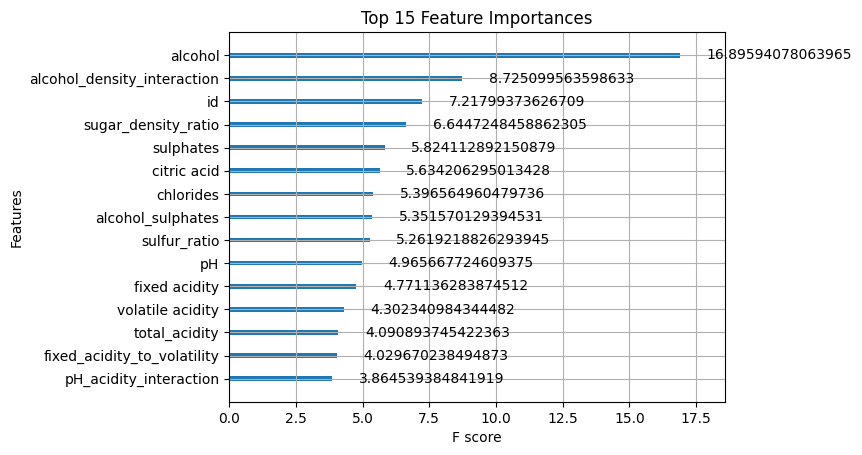

In [132]:
xgb.plot_importance(final_model, importance_type="gain", title="Top 15 Feature Importances")
plt.show()

In [136]:
importances = final_model.get_booster().get_score(importance_type='gain')
importance_df = pd.DataFrame(importances.items(), columns=['Feature', 'Importance'])
importance_df = importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

importance_df

,Feature,Importance
0,alcohol,16.895941
1,alcohol_density_interaction,8.725100
2,id,7.217994
3,sugar_density_ratio,6.644725
4,sulphates,5.824113
5,citric acid,5.634206
6,chlorides,5.396565
7,alcohol_sulphates,5.351570
8,sulfur_ratio,5.261922
9,pH,4.965668


In [151]:
dfTest = pd.read_csv("test.csv")

In [152]:
dfTest["alcohol_sulphates"] = dfTest["alcohol"] * dfTest["sulphates"]
dfTest["volatile_citric"] = dfTest["volatile acidity"] * dfTest["citric acid"]
dfTest["total_acidity"] = dfTest["fixed acidity"] + dfTest["volatile acidity"]

dfTest["sulfur_ratio"] = dfTest["free sulfur dioxide"] / (dfTest["total sulfur dioxide"] + 1e-5)
dfTest["sugar_density_ratio"] = dfTest["residual sugar"] / (dfTest["density"] + 1e-5)
dfTest["fixed_acidity_to_volatility"] = dfTest["fixed acidity"] / (dfTest["volatile acidity"] + 1e-5)
dfTest["alcohol_density_interaction"] = dfTest["alcohol"] * dfTest["density"]
dfTest["pH_acidity_interaction"] = dfTest["pH"] * dfTest["fixed acidity"]


In [154]:
cols_to_drop = [
    'residual sugar',
    'free sulfur dioxide',
    'total sulfur dioxide',
    'density',
    'volatile_citric',  # déjà représentée via d'autres features
    'alcohol_squared',  # pas utilisé
    'sweet_density',    # probablement colinéaire
    'acid_index',       # redondant avec fixed/volatile
    'alc_density',      # redondant avec alcohol_density_interaction
    'log_sulphates'     # non mentionnée/utilisée
]

dfTest.drop(columns=[col for col in cols_to_drop if col in dfTest.columns], inplace=True)

In [155]:
df = dfTest.copy()

In [156]:
df["quality"] = final_model.predict(dfTest)

In [157]:
df.columns

Index(['id', 'fixed acidity', 'volatile acidity', 'citric acid', 'chlorides',
       'pH', 'sulphates', 'alcohol', 'alcohol_sulphates', 'total_acidity',
       'sulfur_ratio', 'sugar_density_ratio', 'fixed_acidity_to_volatility',
       'alcohol_density_interaction', 'pH_acidity_interaction', 'quality'],
      dtype='object')

In [158]:
df =  df[["id" , "quality"]]
df = df.set_index('id')
df.to_csv("ans.csv")